#  <center>  Object Detection Project </center>

---

**Task**
Object Detection

**Dataset**
COCO 2017 (30.919 training images, 1.303 validation images, 10 classes)

**Model Architecture**
- **Backbone**: ResNet-50 (pretrained)
- **Neck**: Feature Pyramid Network (FPN)
- **Head**: YOLO-style Detection Head

In [1]:
import yaml

import cv2
import matplotlib.pyplot as plt

from datasets.coco_dataset import COCODataset
from torch.utils.data import DataLoader

import torch
from torch.utils.tensorboard import SummaryWriter #type: ignore

from models.yolo_detector import Detector
from models.loss import ComputeLoss

In [2]:
# Dataset
from datasets.collate import collate_fn
from utils.preprocess import get_normalize_transform, preprocess_image

# Display image
from utils.show_image import display_image

# Training looo
from src.train import train_one_epoch
from src.val import validate_one_epoch

# Utils
from utils.logs import log_to_tensorboard
from utils.checkpoint import save_model, load_model

# decode, nms
from utils.postprocess import decode_predictions, apply_nms

---

# 0. Configs

In [3]:
with open('configs.yaml', 'r', encoding='utf-8') as f:
    cf = yaml.safe_load(f)

In [4]:
DIR_TRAIN = cf['data']['images']['train']
DIR_VAL = cf['data']['images']['val']

PATH_ANN_TRAIN = cf['data']['annotations']['train']
PATH_ANN_VAL = cf['data']['annotations']['val']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 1. Load dataset

In [6]:
train_dataset = COCODataset(img_dir=DIR_TRAIN, ann_file=PATH_ANN_TRAIN, transform=get_normalize_transform(), selected_cat_ids=cf['data']['selected_ids'])
print('Load train dataset done\n')

val_dataset = COCODataset(img_dir=DIR_VAL, ann_file=PATH_ANN_VAL, transform=get_normalize_transform(), selected_cat_ids=cf['data']['selected_ids'])
print('Load validation dataset done')

loading annotations into memory...
Done (t=2.23s)
creating index...
index created!
Dataset created with 30919 images containing 10 classes.
Load train dataset done

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Dataset created with 1303 images containing 10 classes.
Load validation dataset done


## 1.1. DataLoader

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True, persistent_workers=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False, persistent_workers=True, collate_fn=collate_fn)

In [8]:
# test_train_loader = DataLoader(Subset(train_dataset, range(10)), batch_size=2, num_workers=2, shuffle=True, collate_fn=collate_fn)
# test_val_loader = DataLoader(Subset(val_dataset, range(1)), batch_size=2, num_workers=2, shuffle=False, collate_fn=collate_fn)

In [9]:
# Kích thước tập train và val
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

Train dataset size: 30919
Val dataset size: 1303


## 1.2. Show image with ground truth

Display image: 1
image shape: torch.Size([3, 224, 224])
boxes shape: torch.Size([3, 4])
labels shape: torch.Size([3])


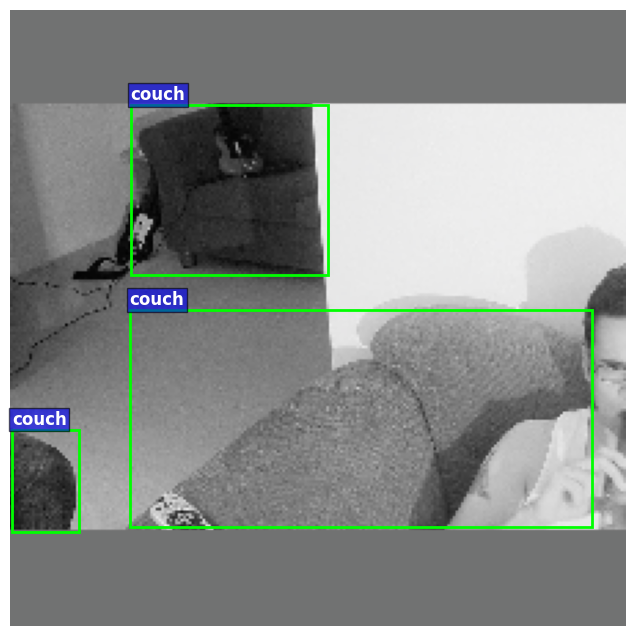

Display image: 2
image shape: torch.Size([3, 224, 224])
boxes shape: torch.Size([4, 4])
labels shape: torch.Size([4])


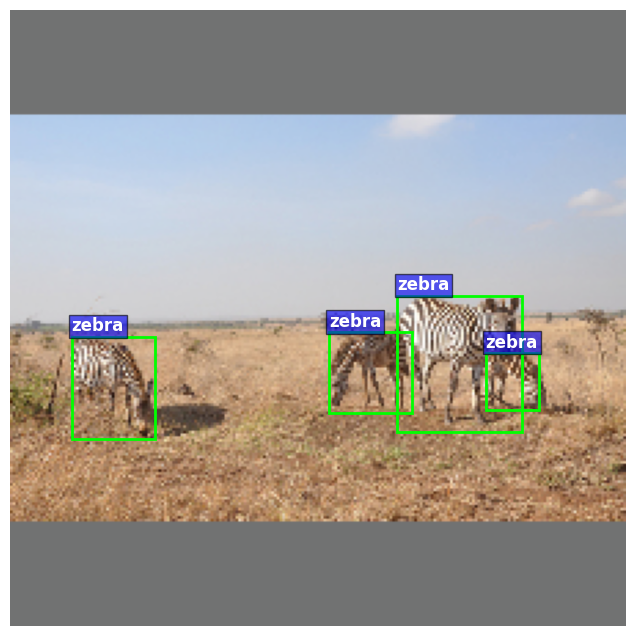

Display image: 3
image shape: torch.Size([3, 224, 224])
boxes shape: torch.Size([5, 4])
labels shape: torch.Size([5])


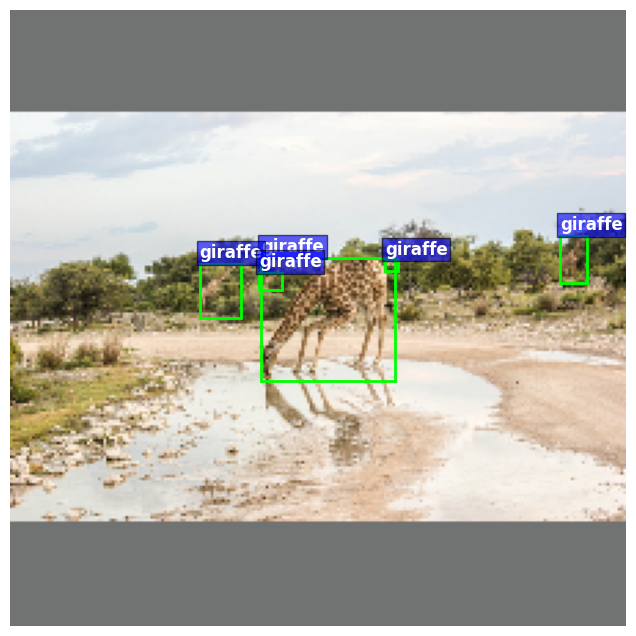

In [31]:
import random 
random.seed(42)

for i in range(3):
    random_number = random.randint(0, len(train_dataset)-1)
    img, target = train_dataset[random_number]

    # image, target shape
    print(f"Display image: {i+1}")
    print(f"image shape: {img.shape}")
    print(f"boxes shape: {target['boxes'].shape}")
    print(f"labels shape: {target['labels'].shape}")

    display_image(img, target=target, israw=True, class_names=cf['data']['labels_categories'])

---

# 2. Models

## 2.1. Model detection

In [ ]:
# backbone: resnet50
# neck: FPN
# head: YOLO-style

model = Detector()
model = model.to(device)
# print(model)

In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.requires_grad}")

backbone.stage3.0.conv1.weight - True
backbone.stage3.0.bn1.weight - True
backbone.stage3.0.bn1.bias - True
backbone.stage3.0.conv2.weight - True
backbone.stage3.0.bn2.weight - True
backbone.stage3.0.bn2.bias - True
backbone.stage3.0.conv3.weight - True
backbone.stage3.0.bn3.weight - True
backbone.stage3.0.bn3.bias - True
backbone.stage3.0.downsample.0.weight - True
backbone.stage3.0.downsample.1.weight - True
backbone.stage3.0.downsample.1.bias - True
backbone.stage3.1.conv1.weight - True
backbone.stage3.1.bn1.weight - True
backbone.stage3.1.bn1.bias - True
backbone.stage3.1.conv2.weight - True
backbone.stage3.1.bn2.weight - True
backbone.stage3.1.bn2.bias - True
backbone.stage3.1.conv3.weight - True
backbone.stage3.1.bn3.weight - True
backbone.stage3.1.bn3.bias - True
backbone.stage3.2.conv1.weight - True
backbone.stage3.2.bn1.weight - True
backbone.stage3.2.bn1.bias - True
backbone.stage3.2.conv2.weight - True
backbone.stage3.2.bn2.weight - True
backbone.stage3.2.bn2.bias - True
bac

In [13]:
total_params = 0

for param in model.parameters():
    if param.requires_grad:
        total_params += param.numel()

print("Total param:", total_params)

Total param: 28337423


## 2.2. Loss

In [14]:
criterion = ComputeLoss()

## 2.3. Optimizer

In [ ]:
NUM_EPOCHS = 35

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,
    eta_min=1e-6
)

---

# 3. Trainning loop

In [16]:
# from datetime import datetime
# from zoneinfo import ZoneInfo

# from torch import GradScaler

# now = datetime.now(ZoneInfo("Asia/Ho_Chi_Minh")).strftime("%d_%m_%Hh%M")
# writer = SummaryWriter(log_dir=f"runs/{now}")
# scaler = GradScaler()

# best_metric = 0.0   # map_50


# for epoch in range(1, NUM_EPOCHS+1):
#     print(f"\n===== Epoch {epoch}/{NUM_EPOCHS} =====")

#     # -------- TRAIN --------
#     train_metrics = train_one_epoch(
#         model=model,
#         optimizer=optimizer,
#         loss_fn=criterion,
#         data_loader=train_loader,
#         device=device,
#         epoch=epoch,
#         scaler=scaler
#     )

#     # -------- VALIDATION --------
#     val_metrics = validate_one_epoch(
#         model=model,
#         loss_fn=criterion,
#         data_loader=val_loader,
#         device=device,
#         epoch=epoch,
#     )


#     if scheduler is not None:
#         scheduler.step()

#     # -------- LOG TENSORBOARD --------
#     log_to_tensorboard(
#         writer=writer,
#         epoch=epoch,
#         train_metrics=train_metrics,
#         val_metrics=val_metrics,
#         optimizer=optimizer,
#     )

#     # -------- SAVE MODEL --------
#     best_metric, is_best = save_model(
#         model=model,
#         optimizer=optimizer,
#         scheduler=scheduler,
#         scaler=scaler,           
#         epoch=epoch,
#         val_metrics=val_metrics,
#         best_metric=best_metric,
#         save_dir="checkpoints",
#         monitor="map_50",
#         mode="max",
#     )

#     # Print result
#     print(
#         f"Train Loss: {train_metrics['total_loss']:.4f} | "
#         f"Val Loss: {val_metrics['val_loss']:.4f} | "
#         f"mAP@0.5: {val_metrics['map_50']:.4f}"
#     )

# 4. Training results

## 4.1. Loss

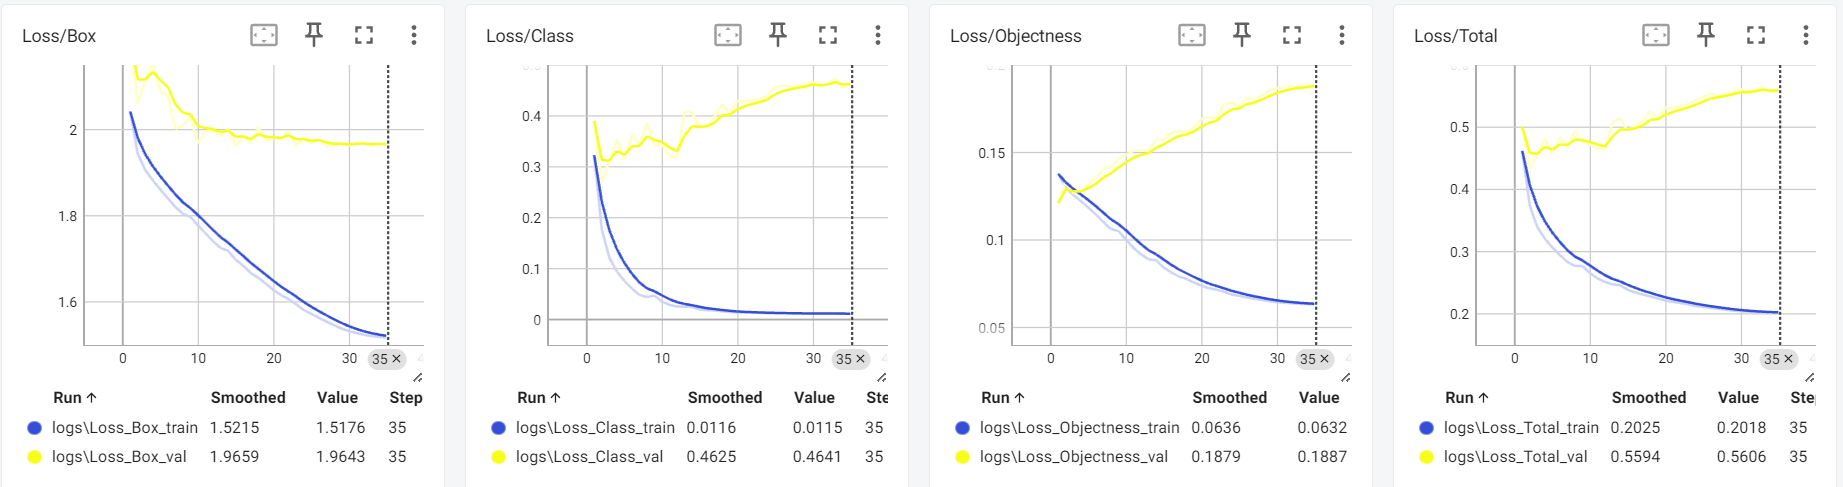

## 4.2. Metrics

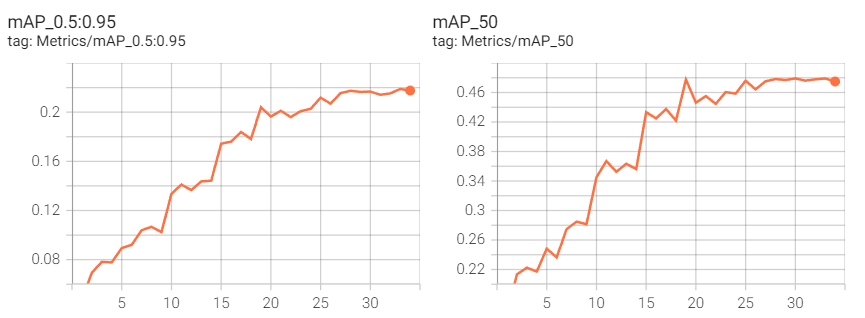

---

## 5. Inference

In [17]:
model = load_model(model, cf['best_model']) # Load model

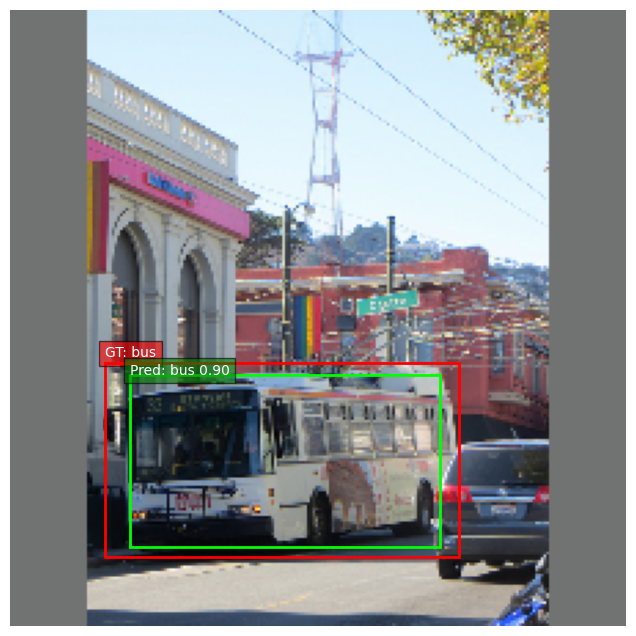

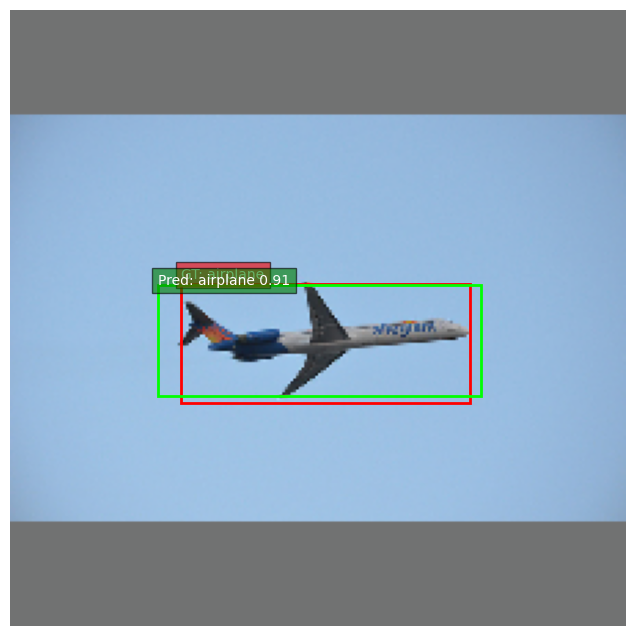

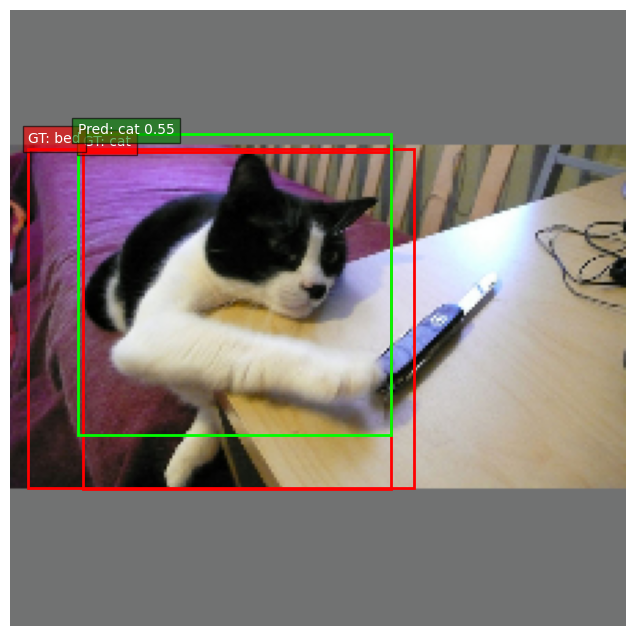

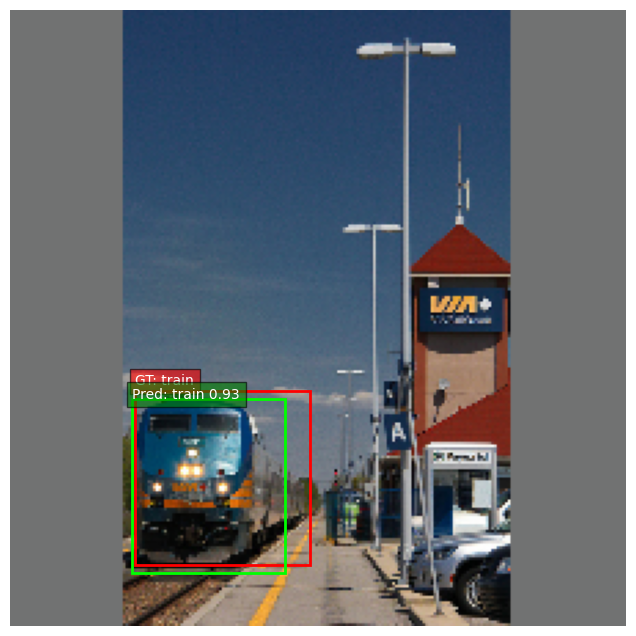

In [ ]:
from utils.visualize_prediction import preds_to_target, display_gt_and_pred

ids_ = [487, 1213, 267, 757]

# random.seed(42)
for i in ids_:
    # num_rand = random.randint(0, len(val_dataset)-1)
    img_tensor, gt = val_dataset[i]

    with torch.no_grad():
        outputs = model(img_tensor.unsqueeze(0).to(device))

    preds = decode_predictions(outputs,conf_thres=0.4)
    final_boxes = apply_nms(preds, iou_thres=0.45)

    pred_target = preds_to_target(final_boxes[0])

    display_gt_and_pred(
        img_tensor,
        gt,
        pred_target,
        class_names=cf["data"]["labels_categories"]
    )